## Análisis de predicción del modelo con imágenes de prueba

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import glob
from ultralytics import YOLO
import numpy as np
from typing import List, Tuple

Se crean funciones auxiliares para tranformar las coordenadas de las etiquetas generadas por YOLO, graficas las cajas y mostrar en la imagen las cajas etiquetadas y las predichas por el modelo

In [9]:
def load_yolo_labels(label_path: str, 
                     img_shape: Tuple[int, int, int]
                     ) -> List[List[int]]:
    """
    Carga las etiquetas YOLO (ground truth) desde un archivo y las convierte 
    a coordenadas absolutas en píxeles basadas en el tamaño de la imagen.

    Args:
        label_path (str): La ruta del archivo que contiene las etiquetas en formato YOLO.
        img_shape (Tuple[int, int, int]): Dimensiones de la imagen en formato (altura, ancho, canales).

    Returns:
        List[List[int]]: Una lista de bounding boxes en formato [x_min, y_min, x_max, y_max].
    """
    h, w, _ = img_shape
    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                # Cada línea es: class x_center y_center width height (valores normalizados entre 0 y 1)
                values = line.strip().split()
                x_center, y_center, width, height = map(float, values[1:])
                # Convertir a formato [x_min, y_min, x_max, y_max] en píxeles
                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)
                bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes


def draw_boxes(image: np.ndarray, 
               bboxes: List[List[int]], 
               color: Tuple[int, int, int], 
               label: str = "") -> None:
    """
    Dibuja bounding boxes en la imagen.

    Args:
        image (np.ndarray): La imagen en la que se dibujarán las bounding boxes.
        bboxes (List[List[int]]): Lista de bounding boxes en formato [x_min, y_min, x_max, y_max].
        color (Tuple[int, int, int]): Color de las bounding boxes en formato (B, G, R).
        label (str, optional): Texto de etiqueta que se dibuja sobre cada bounding box. Defaults a "".
    """
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        if label:
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


def plot_predictions_with_labels(image_files: List[str], 
                                 results: List, 
                                 labels_path: str) -> None:
    """
    Muestra imágenes con las predicciones del modelo y las etiquetas ground truth.

    Args:
        image_files (List[str]): Lista de rutas a las imágenes.
        results (List): Resultados del modelo que contienen las predicciones de las bounding boxes.
        labels_path (str): Ruta a las etiquetas ground truth.
    """
    plt.figure(figsize=(15, 10))
    
    # Iterar sobre las primeras 5 imágenes
    for i, image_file in enumerate(image_files[:6]):
        # Leer la imagen original
        img = cv2.imread(image_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

        # Cargar las etiquetas (ground truth)
        label_file = os.path.join(labels_path, os.path.basename(image_file).replace('.jpg', '.txt'))
        gt_bboxes = load_yolo_labels(label_file, img_rgb.shape)

        # Obtener las predicciones del modelo para esta imagen
        result = results[i]
        pred_bboxes = result.boxes.xyxy.cpu().numpy().astype(int)  # Convertir predicciones a formato [x_min, y_min, x_max, y_max]

        # Crear una copia de la imagen para dibujar las etiquetas originales (ground truth)
        img_with_labels = img_rgb.copy()
        draw_boxes(img_with_labels, gt_bboxes, color=(0, 255, 0), label="Ground Truth")  # Verde para ground truth
        draw_boxes(img_with_labels, pred_bboxes, color=(255, 0, 0), label="Prediction")  # Rojo para predicciones

        # Mostrar la imagen con etiquetas y predicciones
        plt.subplot(2, 3, i+1)
        plt.imshow(img_with_labels)
        plt.axis('off')  # Quitar los ejes
        plt.title(f'Predicción vs Ground Truth {i+1}')

    plt.tight_layout()
    plt.show()

In [5]:
# Carga del modelo YOLO entrenado
model = YOLO('../runs/detect/qr_code_detection2/weights/best.pt')

In [6]:
# Ruta de las imágenes de prueba y sus etiquetas
test_images_path = r'D:\qr_code_detection\model\qr_detection_dataset\test\images'
test_labels_path = r'D:\qr_code_detection\model\qr_detection_dataset\test\labels'

In [7]:
# Predicción de imágenes de prueba con el modelo entrenado
results = model.predict(source=test_images_path)


image 1/155 D:\qr_code_detection\model\qr_detection_dataset\test\images\0050027974_jpg.rf.269ad5f89a28942eb9ccf09507a77b22.jpg: 640x640 1 qr-code, 144.0ms
image 2/155 D:\qr_code_detection\model\qr_detection_dataset\test\images\0465484369_jpg.rf.5a008a07ddeab607b4ee760df70c279c.jpg: 640x640 1 qr-code, 131.2ms
image 3/155 D:\qr_code_detection\model\qr_detection_dataset\test\images\0575557590_jpg.rf.c298437c6e0fac5647c6335f71111142.jpg: 640x640 1 qr-code, 121.2ms
image 4/155 D:\qr_code_detection\model\qr_detection_dataset\test\images\0858847120_jpg.rf.36d3c000258e62b9b28a739e4fd118d3.jpg: 640x640 1 qr-code, 110.3ms
image 5/155 D:\qr_code_detection\model\qr_detection_dataset\test\images\1173_U7cZv88QC_jpg.rf.89d791a0e4ca605b3cc55d765504abe5.jpg: 640x640 1 qr-code, 120.0ms
image 6/155 D:\qr_code_detection\model\qr_detection_dataset\test\images\1317_U7u33GNuC_jpg.rf.baf7f723402c0ad6913c6fbb875f912d.jpg: 640x640 1 qr-code, 122.5ms
image 7/155 D:\qr_code_detection\model\qr_detection_dataset\t

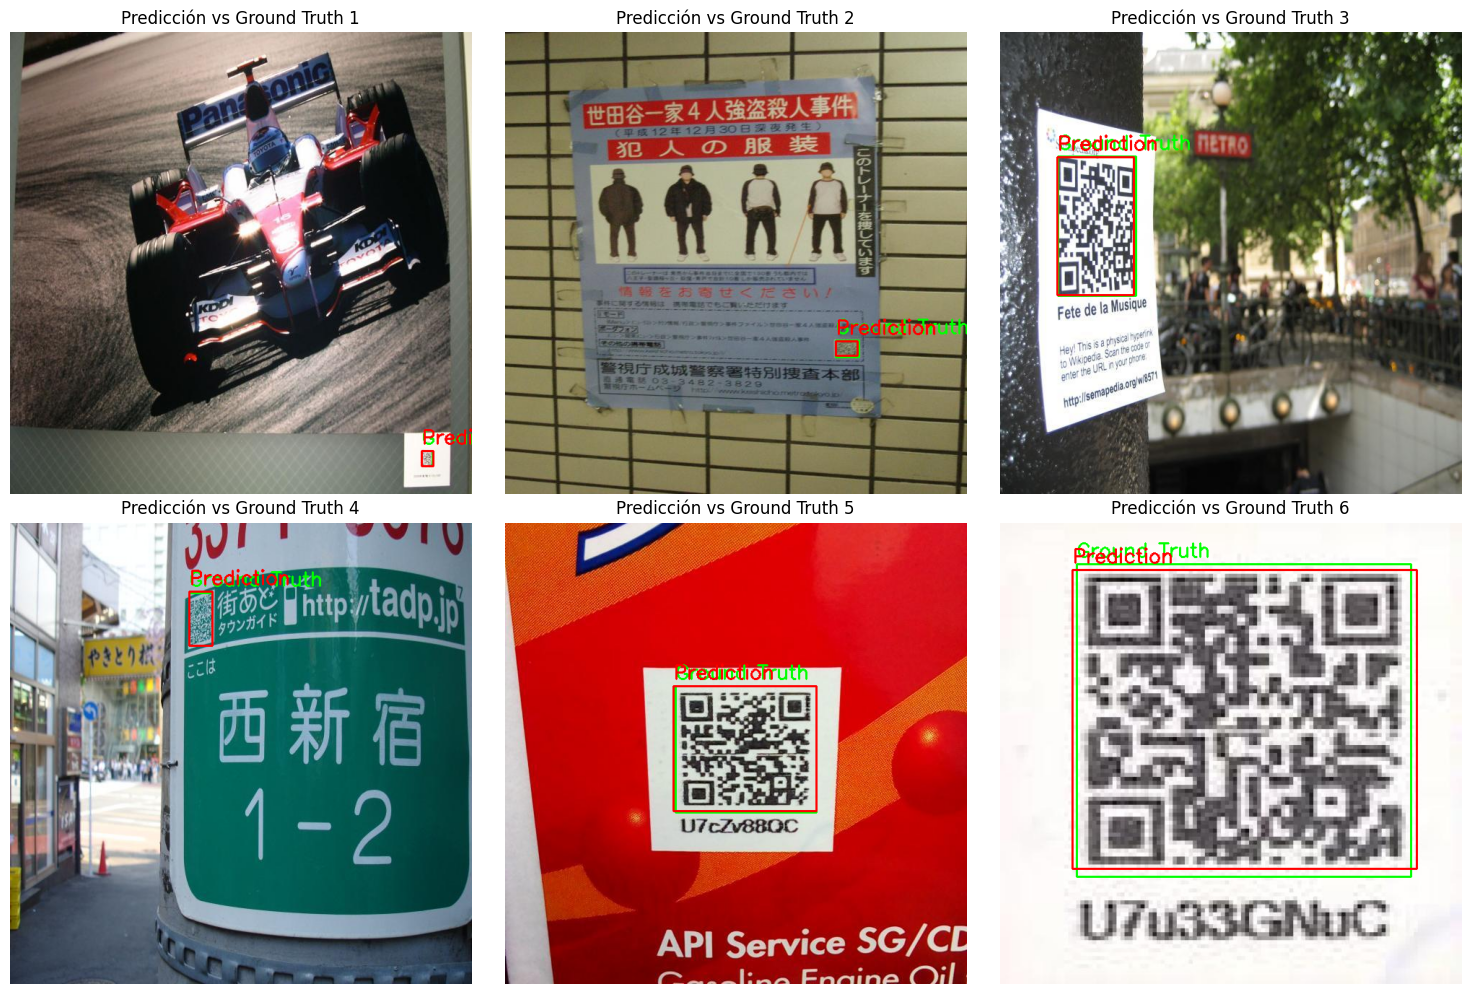

In [10]:
# Obtener las rutas de las imágenes de prueba
image_files = glob.glob(os.path.join(test_images_path, '*.jpg'))

# Mostrar imágenes con las predicciones y las etiquetas originales
plot_predictions_with_labels(image_files, results, test_labels_path)

In [11]:
# Evaluar el modelo en el conjunto de prueba usando YOLO val
results = model.val(data=r'D:\qr_code_detection\model\qr_detection_dataset\data.yaml', split='test')

# Mostrar las métricas calculadas en el conjunto de prueba
metrics = results.results_dict
print(metrics)

Ultralytics YOLOv8.2.90  Python-3.11.9 torch-2.4.1+cpu CPU (Intel Core(TM) i7-8565U 1.80GHz)


val: Scanning D:\qr_code_detection\model\qr_detection_dataset\test\labels.cache... 155 images, 0 backgrounds, 0 corrupt: 100%|██████████| 155/155 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


                   all        155        303      0.986      0.936      0.977      0.799
Speed: 1.6ms preprocess, 117.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val
{'metrics/precision(B)': 0.9860880593738052, 'metrics/recall(B)': 0.9357216465356766, 'metrics/mAP50(B)': 0.9774040314092843, 'metrics/mAP50-95(B)': 0.7993005227193153, 'fitness': 0.8171108735883122}


### Interpretación de métricas sobre el conjunto de prueba

- Precisión alta (0.986): El modelo es muy bueno al hacer predicciones precisas, con muy pocos falsos positivos.
- Recall (0.936): El modelo detecta correctamente la mayoría de los objetos en el conjunto de prueba
- mAP@50 alto (0.977): el modelo tiene un 97.7% de precisión promedio en el conjunto de prueba cuando se requiere que la predicción tenga una superposición de al menos un 50% con la etiqueta real.
- mAP@50-95 razonable (0.799): Aunque el modelo sigue siendo fuerte, su rendimiento disminuye cuando se requiere una superposición más precisa de las cajas (es decir, un mayor nivel de exactitud en las predicciones).
- Fitness (0.817): El modelo tiene un rendimiento general sólido, siendo efectivo en términos de precisión y recall.